### Problem Description

Write some details of the problem ... also mention the link of the dataset

### Import Packages

In [116]:
# Add environment Packages paths to conda
import os, sys
# env_name = "food_review"
# sys.path.append(f"C:\\Environments\\{env_name}\\lib\\site-packages\\")

import pandas as pd
import numpy as np

# Text preprocessing packages
import nltk # Text libarary
# nltk.download('stopwords')
import string # Removing special characters {#, @, ...}
import re as re # Regex Package
from nltk.corpus import stopwords # Stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer # Stemmer & Lemmatizer
from gensim.utils import simple_preprocess  # Text ==> List of Tokens

# Text Embedding
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Saving Model
import pickle

# Visualization Packages
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)
%matplotlib inline

### Read Dataset

In [117]:
%%time
df = pd.read_csv('Reviews.csv')

Wall time: 4.97 s


In [118]:
f"{df.shape[0]:,} Review"

'568,454 Review'

In [119]:
cols = ['Text', 'Score']
df_text = df[cols].copy()
df_text.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


### Drop Duplicates
Save the Cleaned data-frame also with the variable `df_text`

In [120]:
df_text.drop_duplicates('Text',inplace=True)
df_text.reset_index(drop=True, inplace=True)
f"{df_text.shape[0]:,} Review"

'393,579 Review'

In [121]:
df_text.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


### Target Variable Pre-Processing
`target` will be 
 - 0 if score < 3 
 - 1 otherwise

In [122]:
df_text['target'] = [0 if i < 3 else 1 for i in df_text['Score']]

In [123]:
df_text.head()

,Text,Score,target
0,I have bought several of the Vitality canned d...,5,1
1,Product arrived labeled as Jumbo Salted Peanut...,1,0
2,This is a confection that has been around a fe...,4,1
3,If you are looking for the secret ingredient i...,2,0
4,Great taffy at a great price. There was a wid...,5,1


In [124]:
df_text['target'].value_counts()

1    336512
0     57067
Name: target, dtype: int64

#### Plot Countplot for target Variable

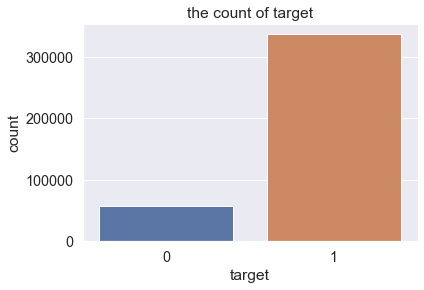

In [125]:
sns.countplot(x=df_text['target']);
plt.title('the count of target');


Notice how such variance is huge ...   
Then we need to down-sample such data ... by which both the positive and negative classes are balanced.

### Balance Data Target

In [126]:
df_text.reset_index(drop=True, inplace=True)

In [127]:
# Sample from positive reviews Same number of negative reviews
NEG_N = df_text.target.value_counts()[0]
df_pos = df_text[df_text['target'] == 1]['Text'].sample(NEG_N, replace=False)
df_text_balanced = pd.concat([df_text.iloc[df_pos.index], df_text[df_text.target == 0]]).reset_index()
df_text_balanced.drop('index',axis=1,inplace=True)

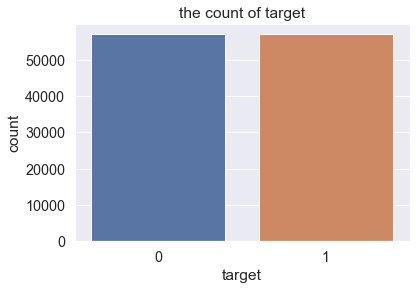

In [128]:
## PLot the target again after balancing
## Write your code here
sns.countplot(x=df_text_balanced['target']);
plt.title('the count of target');


### Text Pre-Processing

In [129]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MarawanEmadAbdElHame\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MarawanEmadAbdElHame\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package wordnet is already up-to-date!


True

In [130]:
def Cleaning(strr):
    strr = re.sub("\\<.*?\\>", "", strr)  # Removing tags html from string
    strr = re.sub(r"http\S+", '', strr)  # Removing html links from string
    strr = re.sub(r"www\S+" , '', strr)  # Removing www links from string
    strr = re.sub("&[a-z0-9]+|&#[0-9]{1,6}|&#x[0-9a-f]{1,6}", '',strr) # Removing unrecognized words 
    strr = re.sub("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b",' ',strr) # Removing repeated character   
    strr = re.sub("[^A-Za-z']+", " ", strr)   # Removing any brackets or special character or numbers 
    strr = re.sub(r'(Mr|Ms|Mrs)\.?\s[A-Z]\w*', " ", strr) # Removing names from strings 
    strr = " ".join(strr.split()) # adjusting the spaces in string
    return strr
df_text_balanced['Text']= df_text_balanced['Text'].str.lower().str.strip()
df_text_balanced['Text']= df_text_balanced['Text'].apply(Cleaning)
df_text_balanced['Text']= df_text_balanced['Text'].str.strip()

In [132]:
def Updated_text(strr):
    strr = re.sub(r"won't", "will not", strr)
    strr = re.sub(r"can\'t", "can not", strr)
    strr = re.sub(r"n\'t", " not", strr)
    strr = re.sub(r"\'re", " are", strr)
    strr = re.sub(r"\'s", " is", strr)
    strr = re.sub(r"\'d", " would", strr)
    strr = re.sub(r"\'ll", " will", strr)
    strr = re.sub(r"\'t", " not", strr)
    strr = re.sub(r"\'ve", " have", strr)
    strr = re.sub(r"\'m", " am", strr)
    return strr
df_text_balanced['Text']= df_text_balanced['Text'].apply(Updated_text)
df_text_balanced['Text']= df_text_balanced['Text'].str.strip()

In [133]:
df_text_balanced.head()

,Text,Score,target
0,i got the great taste that i was looking for w...,4,1
1,of course they are not really kimchi but who c...,5,1
2,i began drinking coffee only a couple years ag...,5,1
3,this tastes like regular tea mixed with vanill...,3,1
4,this oil is very good to cook with when heated...,5,1


In [134]:
stop_words = set(stopwords.words('english'))
stop_words.remove('not')


In [135]:
def stopWords(text):
    x = ' '
    lst=list()
    for word in text.split():
        if word not in stop_words:
            lst.append(word)
    return x.join(lst)
df_text_balanced['Text']=df_text_balanced['Text'].apply(stopWords)
#df_text_balanced['Text']=df_text_balanced['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


In [136]:
df_text_balanced.head()

,Text,Score,target
0,got great taste looking fruit gems arrived not...,4,1
1,course not really kimchi cares like reconstitu...,5,1
2,began drinking coffee couple years ago tried t...,5,1
3,tastes like regular tea mixed vanilla creamer ...,3,1
4,oil good cook heated low viscosity tends coat ...,5,1


In [137]:
stemmer = SnowballStemmer("english")
lemmatizer= WordNetLemmatizer()

In [138]:
def lemmatization(text):
    x = ' '
    ls = list()
    for word in text.split():
        ls.append(lemmatizer.lemmatize(word))
    return x.join(ls)
    
df_text_balanced['Text'] = df_text_balanced['Text'].apply(lemmatization)

In [139]:
df_text_balanced.head()

,Text,Score,target
0,got great taste looking fruit gem arrived not ...,4,1
1,course not really kimchi care like reconstitut...,5,1
2,began drinking coffee couple year ago tried tw...,5,1
3,taste like regular tea mixed vanilla creamer p...,3,1
4,oil good cook heated low viscosity tends coat ...,5,1


In [140]:
def stemming(text):
    x = ' '
    ls = list()
    for word in text.split():
        ls.append(stemmer.stem(word))
    return x.join(ls)

df_text_balanced['Text'] = df_text_balanced['Text'].apply(stemming)

In [141]:
df_text_balanced.head()

,Text,Score,target
0,got great tast look fruit gem arriv not easili...,4,1
1,cours not realli kimchi care like reconstitut ...,5,1
2,began drink coffe coupl year ago tri twenti di...,5,1
3,tast like regular tea mix vanilla creamer powd...,3,1
4,oil good cook heat low viscos tend coat pan fo...,5,1


### Split Test & Training Data

In [142]:
X = df_text_balanced['Text']
y = df_text_balanced['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Text Embedding
 - Use `TfidfVectorizer`
 - `fit` on the training data only
 - `transform` on training and test 

In [143]:
## TFIDF embedding for the Description
vectorizer = TfidfVectorizer()
# fit on training (such vectorizer will be saved for deployment)
vectorizer_tfidf = vectorizer.fit(X)
# transform on training data
X_train = vectorizer_tfidf.transform(X_train)
# transform on testing data
X_test = vectorizer_tfidf.transform(X_test)

In [144]:
# See the dimensions of your data embeddings before entering to the model
X_train.shape, X_test.shape


((79893, 47127), (34241, 47127))

### Modelling

In [145]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

##### Sklearn framework steps
 - init
 - fit
 - predict

In [146]:
## initialize your Model
clf = RandomForestClassifier(random_state=0) 
# Fit your Model on the Training Dataset
clf.fit(X_train, y_train)
# Predict on Test data
preds = clf.predict(X_test)
# Calculate Model Accuracy
acc = accuracy_score(preds, y_test)
print(f"Model Accuracy = {round(acc*100,2)}%")

Model Accuracy = 84.52%


### Raw Instance Prediction

In [149]:
def raw_test(review, model, vectorizer):
    # Clean Review
    review_c = Cleaning(review)
    review_c = Updated_text(review_c)
    review_c = stopWords(review_c)
    review_c = lemmatization(review_c)
    review_c = stemming(review_c)
    # Embed review using tf-idf vectorizer
    embedding = vectorizer.transform([review_c])
    # Predict using your model
    prediction =model.predict(embedding)
    # Return the Sentiment Prediction
    return "Positive" if prediction == 1 else "Negative"

In [150]:
review_1 = "That's a good Dish, Good Job"
review_2 = "That's the worst Dish ever tasted"

In [151]:
raw_test(review_1, clf, vectorizer_tfidf)

'Positive'

In [152]:
raw_test(review_2, clf, vectorizer_tfidf)

'Negative'

### Saving Models for Deployment

In [153]:
import pickle

In [154]:
... ## Save model
model_name = 'rf_model.pk'
model_path = os.path.join('F:/Career Projects/', model_name)
pickle.dump(clf, open(model_path, 'wb'))

... ## Save tfidf-vectorizer
vectorizer_name = 'tfidf_vectorizer.pk'
vectorizer_path = os.path.join('F:/Career Projects/', vectorizer_name)
pickle.dump(vectorizer, open(vectorizer_path, "wb"))

### Load model Again and test them

In [155]:
loaded_model = pickle.load(open(model_path,'rb'))
loaded_vect = pickle.load(open(vectorizer_path,'rb'))

In [156]:
raw_test(review_1, loaded_model, loaded_vect)

'Positive'

In [157]:
raw_test(review_2, loaded_model, loaded_vect)

'Negative'

# Great Job !
### Now Deploy your ML model using Streamlit Framework

In [158]:
!pip install -q pyngrok

!pip install -q streamlit

!pip install -q streamlit_ace

In [1]:
%%writefile project.py
import pickle
import streamlit as st
import nltk # Text libarary
# nltk.download('stopwords')
import string # Removing special characters {#, @, ...}
import re as re # Regex Package
from nltk.corpus import stopwords # Stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer # Stemmer & Lemmatizer
from gensim.utils import simple_preprocess  # Text ==> List of Tokens

model_path = 'F:/Career Projects/rf_model.pk'
vectorizer_path = 'F:/Career Projects/tfidf_vectorizer.pk'
model = pickle.load(open(model_path,'rb'))
vectorizer = pickle.load(open(vectorizer_path,'rb'))

def Cleaning(strr):
    strr = re.sub("\\<.*?\\>", "", strr)  # Removing tags html from string
    strr = re.sub(r"http\S+", '', strr)  # Removing html links from string
    strr = re.sub(r"www\S+" , '', strr)  # Removing www links from string
    strr = re.sub("&[a-z0-9]+|&#[0-9]{1,6}|&#x[0-9a-f]{1,6}", '',strr) # Removing unrecognized words 
    strr = re.sub("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b",' ',strr) # Removing repeated character   
    strr = re.sub("[^A-Za-z']+", " ", strr)   # Removing any brackets or special character or numbers 
    strr = re.sub(r'(Mr|Ms|Mrs)\.?\s[A-Z]\w*', " ", strr) # Removing names from strings 
    strr = " ".join(strr.split()) # adjusting the spaces in string
    return strr

def Updated_text(strr):
    strr = re.sub(r"won't", "will not", strr)
    strr = re.sub(r"can\'t", "can not", strr)
    strr = re.sub(r"n\'t", " not", strr)
    strr = re.sub(r"\'re", " are", strr)
    strr = re.sub(r"\'s", " is", strr)
    strr = re.sub(r"\'d", " would", strr)
    strr = re.sub(r"\'ll", " will", strr)
    strr = re.sub(r"\'t", " not", strr)
    strr = re.sub(r"\'ve", " have", strr)
    strr = re.sub(r"\'m", " am", strr)
    return strr


def stopWords(text):
    x = ' '
    lst=list()
    for word in text.split():
        if word not in stop_words:
            lst.append(word)
    return x.join(lst)
    

def lemmatization(text):
    x = ' '
    ls = list()
    for word in text.split():
        ls.append(lemmatizer.lemmatize(word))
    return x.join(ls)


def stemming(text):
    x = ' '
    ls = list()
    for word in text.split():
        ls.append(stemmer.stem(word))
    return x.join(ls)

stemmer = SnowballStemmer("english")
lemmatizer= WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
stop_words.remove('not')
def prediction(review, model, vectorizer):
    # Clean Review
    review_c = Cleaning(review)
    review_c = Updated_text(review_c)
    review_c = stopWords(review_c)
    review_c = lemmatization(review_c)
    review_c = stemming(review_c)
    # Embed review using tf-idf vectorizer
    embedding = vectorizer.transform([review_c])
    # Predict using your model
    prediction =model.predict(embedding)
    # Return the Sentiment Prediction
    return "Positive" if prediction == 1 else "Negative"

def main() :
    
    primaryColor=""
    base="dark"
    from PIL import Image
    img = Image.open("Amazone_image.png")
    st.image(img, use_column_width=True)
    primaryColor="red"
    st.title('Amazon Food Review')
    st.subheader("Analyze Your Text")
    text = st.text_area('Enter your Review',height=35)
    if st.button('Analyse'):
        pred= prediction(text,model,vectorizer)
        if pred =='Positive':
            return st.success(pred)
        else :
            return st.error(pred)


if __name__=='__main__': 
    main()

Overwriting project.py


In [60]:
!streamlit run project.py

^C


In [2]:
from pyngrok import ngrok
public_url = ngrok.connect('8501')
public_url 

<NgrokTunnel: "http://aeab-102-47-53-218.ngrok.io" -> "http://localhost:8501">

t=2021-08-26T22:33:54+0200 lvl=eror msg="heartbeat timeout, terminating session" obj=csess id=5007074f572a clientid=7a08cb20c315fcc321e3acb6a1289dd8
t=2021-08-26T22:33:54+0200 lvl=eror msg="session closed, starting reconnect loop" obj=csess id=838cf9ce8a9f err="session closed"


In [1]:
! pip install watchdog 